In [1]:
%load_ext autoreload  
%autoreload 2  

In [2]:
from ocpy.data import Data
# data okuma check

data = Data.from_file("ny_vir.xlsx")
data = data.calculate_weights()

(<Figure size 1000x540 with 1 Axes>, <Axes: xlabel='Cycle', ylabel='O−C'>)

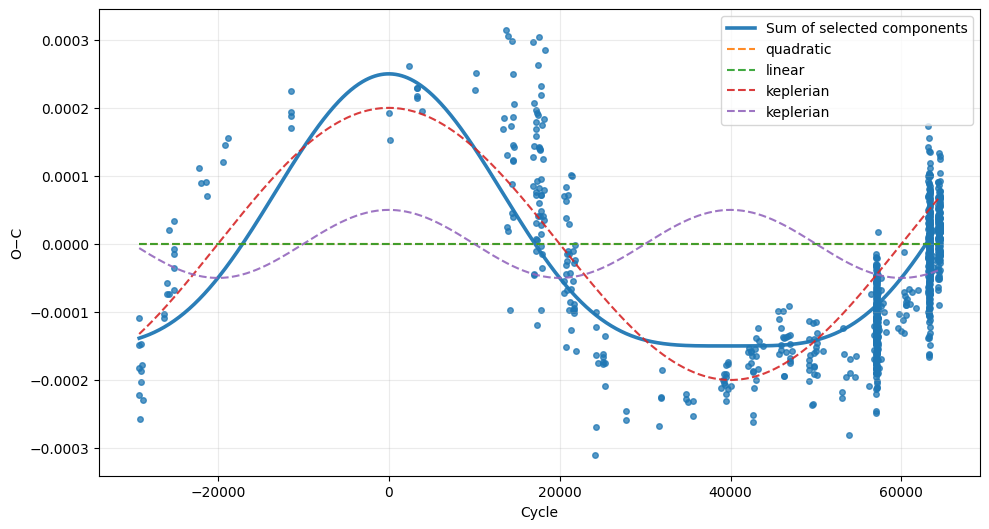

In [3]:
from ocpy.oc import Linear, Quadratic, Keplerian, Parameter

oc = data.calculate_oc(reference_minimum=2453174.442769,
                       reference_period=0.101015969,
                       model_type="pymc")
oc = oc[oc["labels"] != "vis"]

# 1) Linear (y = a*x + b)
lin = Linear(
    a=Parameter(value=0.0,   std=2e-5,  min=-1e-3,  max=1e-3,  fixed=False),
    b=Parameter(value=0.0,   std=2e-3,  min=-0.1,   max=0.1,   fixed=False),
)

# 2) Quadratic (q * x^2)
quad = Quadratic(
    q=Parameter(value=0.0,   std=5e-10, min=-1e-8,  max=1e-8,  fixed=False),
)

# 3) Keplerian #1 (yaklaşık 80k epoch)
lite1 = Keplerian(
    P     = Parameter(value=80000,  std=8_000,  min=30_000,  max=150_000, fixed=False),
    T0    = Parameter(value=60000,  std=5_000,                          fixed=False),
    amp   = Parameter(value=2.0e-4, std=1.0e-4, min=0.0,    max=1.0e-3,  fixed=False),
    e     = Parameter(value=0.0,    fixed=True),
    omega = Parameter(value=0.0,    fixed=True),
)

# 4) Keplerian #2 (yaklaşık 40k epoch)
lite2 = Keplerian(
    P     = Parameter(value=40000,  std=6_000,  min=10_000,  max=100_000, fixed=False),
    T0    = Parameter(value=30000,  std=5_000,                          fixed=False),
    amp   = Parameter(value=5.0e-5, std=2.5e-5, min=0.0,    max=5.0e-4,  fixed=False),
    e     = Parameter(value=0.0,    fixed=True),
    omega = Parameter(value=0.0,    fixed=True),
)

oc.plot_components_on_data([quad, lin, lite1, lite2])


In [4]:
res = oc.fit([lin, quad, lite1, lite2],
             progressbar=True, draws=1000, tune=1000, chains=4,
             target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [linear1_a, linear1_b, quadratic2_q, keplerian3_amp, keplerian3_P, keplerian3_T0, keplerian4_amp, keplerian4_P, keplerian4_T0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.


c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='keplerian3_T0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='keplerian4_T0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='linear1_a'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='linear1_b'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='quadratic2_q'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='keplerian3_amp'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='keplerian3_P'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='keplerian3_T0', ylabel='keplerian4_amp'>,
        <Axes: xlabel='keplerian4_T0'>, <Axes: xlabel='linear1_a'>,
        <Axes: xlabel='linear1_b'>, <Axes: 

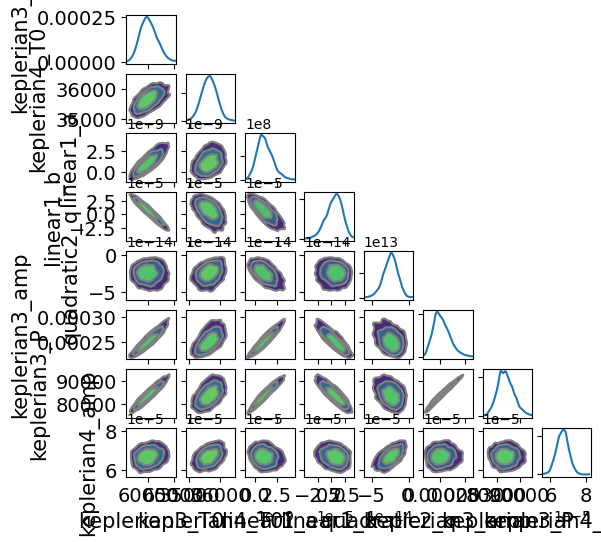

In [5]:
oc.create_corner_plot(res)

In [6]:
res.posterior

<xarray.Dataset> Size: 27MB
Dimensions:         (chain: 4, draw: 1000, y_model_dim_0: 847)
Coordinates:
  * chain           (chain) int64 32B 0 1 2 3
  * draw            (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * y_model_dim_0   (y_model_dim_0) int64 7kB 0 1 2 3 4 ... 842 843 844 845 846
Data variables:
    keplerian3_T0   (chain, draw) float64 32kB 5.947e+04 5.894e+04 ... 5.901e+04
    keplerian4_T0   (chain, draw) float64 32kB 3.562e+04 3.56e+04 ... 3.552e+04
    linear1_a       (chain, draw) float64 32kB 2.551e-10 2.124e-10 ... 2.976e-10
    linear1_b       (chain, draw) float64 32kB 1.158e-05 1.663e-05 ... 1.368e-05
    quadratic2_q    (chain, draw) float64 32kB -1.44e-14 ... -2.013e-14
    keplerian3_amp  (chain, draw) float64 32kB 0.0002411 0.0002386 ... 0.0002407
    keplerian3_P    (chain, draw) float64 32kB 8.177e+04 8.132e+04 ... 8.112e+04
    keplerian4_amp  (chain, draw) float64 32kB 7.035e-05 6.833e-05 ... 6.713e-05
    keplerian4_P    (chain, draw) float64 32kB 3.127e+04 3.122e+04 ... 3.099e+04
    y_model         (chain, draw, y_model_dim_0) float64 27MB -0.0001616 ... ...
Attributes:
    created_at:                 2025-11-09T10:09:23.757813+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              347.6280553340912
    tuning_steps:               1000

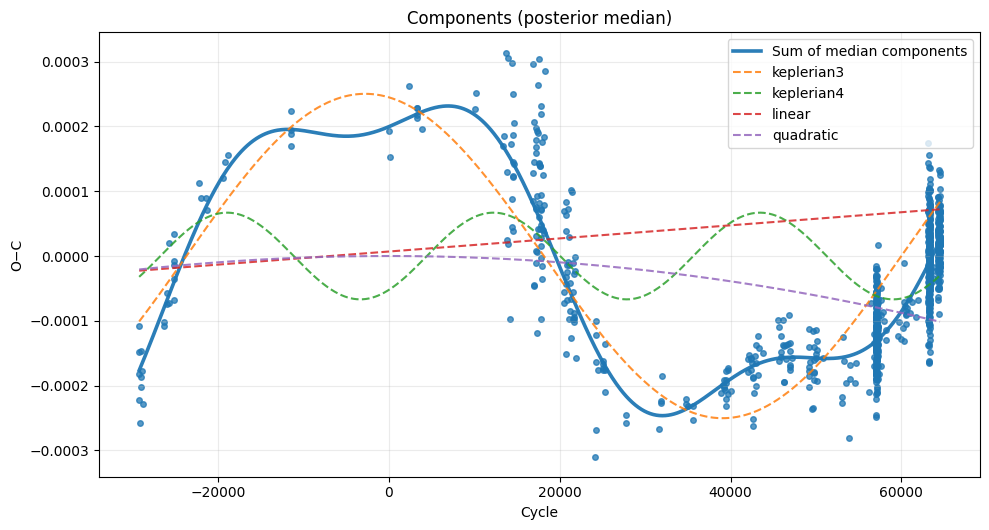

In [7]:
oc.fit_and_report(res)

In [8]:
res.posterior.median()

<xarray.Dataset> Size: 80B
Dimensions:         ()
Data variables:
    keplerian3_T0   float64 8B 5.999e+04
    keplerian4_T0   float64 8B 3.565e+04
    linear1_a       float64 8B 1.011e-09
    linear1_b       float64 8B 6.917e-06
    quadratic2_q    float64 8B -2.438e-14
    keplerian3_amp  float64 8B 0.0002504
    keplerian3_P    float64 8B 8.367e+04
    keplerian4_amp  float64 8B 6.693e-05
    keplerian4_P    float64 8B 3.119e+04
    y_model         float64 8B -1.346e-05

(<Figure size 1000x540 with 1 Axes>, <Axes: xlabel='Cycle', ylabel='O−C'>)

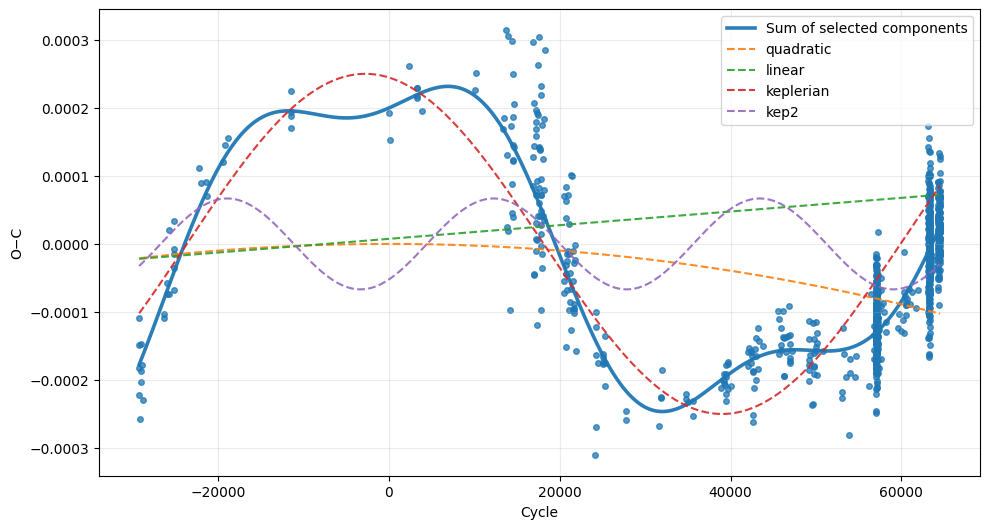

In [9]:
lin = Linear(
    a=Parameter(value=1.005e-09, fixed=False),
    b=Parameter(value=7.428e-06, fixed=False),
)

quad = Quadratic(
    q=Parameter(value=-2.464e-14, fixed=False),
)

lite1 = Keplerian(
    P=Parameter(value=8.352e+04, fixed=False),
    T0=Parameter(value=5.989e+04, fixed=False),
    amp=Parameter(value=0.00025, fixed=False),
    e=Parameter(value=0.0, fixed=True),
    omega=Parameter(value=0.0, fixed=True),
)

lite2 = Keplerian(
    name="kep2",
    P=Parameter(value=3.117e+04, fixed=False),
    T0=Parameter(value=3.564e+04, fixed=False),
    amp=Parameter(value=6.681e-05, fixed=False),
    e=Parameter(value=0.0, fixed=True),
    omega=Parameter(value=0.0, fixed=True),
)

oc.plot_components_on_data([quad, lin, lite1, lite2])